In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob #glob is a python version of running the UNIX ls command. Comes in handy for finding files
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.cadc import Cadc

1. The sample size with all those restriction was pretty small. Try removing the requirment that the spectrum be good by removing that boolean mask.
2. Collect the redshift data of the new sample as well.
3. Plot up in a single figure or across multiple figures/pages (PdfPages module) the object specrta next to 1 object image. Include the object title and redshift

In [3]:
# mayyybe make a function to do this and return the samp_* objs, feed this into the SkyCoord  part of the code // or create coords obj in this func?

#Read in the LEGA-C catalog fits
cat = './legac_dr2_cat.fits'
cat_tab = Table.read(cat, format='fits')
# print(cat_tab.info())

secondary = cat_tab['f_primary'] != 1 
# good_z = cat_tab['f_z'] == 0
good_sn = cat_tab['SN'] >= 15
good_spec = cat_tab['f_spec'] == 0
mask = np.all([secondary, good_sn, good_spec], axis=0) 
print("%d objects found."%(mask.sum()))


samp_filenames = cat_tab['Filename'][mask]
samp_ra = cat_tab['RAJ2000'][mask]
samp_dec = cat_tab['DECJ2000'][mask]
samp_specid = cat_tab['SPECT_ID'][mask]

#collect redshift data
samp_z = cat_tab['z'][mask]

12 objects found.


In [4]:
print(samp_filenames)
print(samp_ra)
print(samp_dec)
print(samp_specid)
print(samp_z)

         Filename         
--------------------------
legac_M4_109742_v2.0.fits 
legac_M9_214843_v2.0.fits 
legac_M9_217006_v2.0.fits 
legac_M9_217545_v2.0.fits 
legac_M10_203467_v2.0.fits
legac_M10_218593_v2.0.fits
legac_M11_255083_v2.0.fits
legac_M11_257594_v2.0.fits
legac_M13_247966_v2.0.fits
legac_M13_261993_v2.0.fits
legac_M15_88722_v2.0.fits 
legac_M15_90894_v2.0.fits 
     RAJ2000      
       deg        
------------------
150.33006286621094
150.33706665039062
150.09068298339844
 150.1287384033203
150.40151977539062
 150.1987762451172
149.88575744628906
149.87083435058594
149.79515075683594
149.79234313964844
 150.4936065673828
150.47836303710938
     DECJ2000     
       deg        
------------------
2.0703179836273193
 2.575268030166626
2.6000239849090576
2.6068739891052246
 2.790821075439453
2.6195719242095947
2.7081520557403564
 2.743256092071533
2.6168830394744873
2.7999320030212402
2.2388250827789307
2.2713100910186768
 SPECT_ID 
----------
M4_109742 
M9_214843 
M9_21700

In [5]:
#Create SkyCoord object using Astropy and the first object's coordinates

#TRY TO loop thru the samp_ra, samp_dec for each file in samp_filenames to query

# for i, file in enumerate(samp_filenames):
coords = SkyCoord(ra=samp_ra[0]*u.degree,dec=samp_dec[0]*u.degree) 
cadc = Cadc()
#size of cutout images
#Radius of cutout in degrees
radius = 5.5*u.arcsecond
result = cadc.query_region(coords,radius=radius,collection='HST')

In [35]:
# #Create a CADC object and query it using query region (coordinates and cutout around our object) for the HST collection
# cadc = Cadc()
# result = cadc.query_region(coords,radius=radius,collection='HST')
# # result is an astropy Table object -- we can use similar operations above to quickly identify images we'd like--namely those that are final products or composite images that have been reduced.

In [53]:
#Select entries above calibration level 2 and for the ACS instrument
result_cal = result[np.logical_and(result['calibrationLevel'] > 2,result['instrument_name'] == 'ACS/WFC')]
#Grabs composite images
result_comp = result_cal[result_cal['typeCode']=='C']

#Shows table in line
result_comp

observationURI,sequenceNumber,metaReadGroups,proposal_keywords,obsID,collection,observationID,algorithm_name,type,intent,metaRelease,proposal_id,proposal_pi,proposal_project,proposal_title,target_name,target_targetID,target_standard,target_redshift,target_moving,target_keywords,targetPosition_equinox,targetPosition_coordinates_cval1,targetPosition_coordinates_cval2,telescope_geoLocationX,telescope_geoLocationY,target_type,targetPosition_coordsys,telescope_name,telescope_geoLocationZ,telescope_keywords,instrument_keywords,environment_seeing,environment_humidity,environment_elevation,environment_tau,environment_wavelengthTau,environment_ambientTemp,environment_photometric,requirements_flag,instrument_name,members,typeCode,metaProducer,metaChecksum,accMetaChecksum,lastModified,maxLastModified,planeURI,publisherID,obsID2,planeID,productID,metaRelease2,metaReadGroups2,dataReadGroups,calibrationLevel,dataRelease,dataProductType,provenance_name,provenance_version,provenance_reference,provenance_producer,provenance_project,provenance_runID,provenance_keywords,provenance_inputs,provenance_lastExecuted,metrics_sourceNumberDensity,metrics_background,metrics_backgroundStddev,metrics_fluxDensityLimit,metrics_magLimit,position_bounds,position_bounds_samples,position_bounds_size,position_resolution,position_sampleSize,position_dimension_naxis1,position_dimension_naxis2,position_timeDependent,quality_flag,position_resolutionBounds [2],energy_bounds_samples,energy_bounds_lower,energy_bounds_upper,energy_bounds_width,energy_dimension,energy_resolvingPower,energy_sampleSize,energy_bounds [2],energy_resolvingPowerBounds [2],energy_emBand,energy_freqWidth,energy_freqSampleSize,energy_restwav,time_bounds_samples,time_bounds_lower,time_bounds_upper,time_bounds_width,time_dimension,time_resolution,time_sampleSize,energy_energyBands,time_exposure,energy_bandpassName,polarization_dimension,energy_transition_species,energy_transition_transition,time_bounds [2],time_resolutionBounds [2],polarization_states,custom_ctype,custom_bounds_samples,custom_bounds_lower,custom_bounds_upper,custom_bounds_width,custom_dimension,metaProducer2,custom_bounds [2],lastModified2,maxLastModified2,metaChecksum2,accMetaChecksum2
,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,,,,,,arcsec,,deg,,m,C,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1 / deg2,Jy / pix,Jy / pix,Jy,,deg,deg,deg,arcsec,arcsec,,,,,arcsec,m,m,m,m,,,m,m,,,Hz,Hz,m,d,d,d,d,,d,d,,s,,,,,d,d,,,,,,,,,,,,,
object,int32,object,object,bytes36,bytes32,bytes128,bytes32,bytes32,bytes32,bytes23,bytes128,bytes128,bytes32,bytes256,bytes32,bytes32,int32,float64,int32,object,float64,float64,float64,float64,float64,bytes32,bytes16,bytes32,float64,object,object,float64,float64,float64,float64,float64,float64,int32,bytes16,bytes32,object,bytes1,object,object,object,bytes23,bytes23,object,object,bytes36,bytes36,bytes64,bytes23,object,object,int32,bytes23,bytes128,bytes128,bytes32,bytes256,bytes128,bytes256,bytes64,object,object,bytes23,float64,float64,float64,float64,float64,object,object,float64,float64,float64,int64,int64,int32,bytes16,float64,object,float64,float64,float64,int64,float64,float64,float64,float64,bytes32,float64,float64,float64,object,float64,float64,float64,int64,float64,float64,bytes32,float64,bytes32,int64,bytes32,bytes32,float64,float64,bytes32,bytes32,object,float64,float64,float64,int64,object,float64,bytes23,bytes23,object,object
caom:HST/jcor23010,--,,,00000000-0000-0000-a8a0-e0c7cc711cf4,HST,jcor23010,drizzle,IMAGING,science,2015-05-09T05:42:59.000,13657,"Kartaltepe, Jeyhan",GO,Probing the Most Luminous Galaxies in the Universe at the Peak of Galaxy Assembly,ANY,,0,--,0,BROAD_CATEGORY=UNIDENTIFIED|TARGET_DESCRIP=UNIDENTIFIED;PARALLEL FIELD,2000.0,150.354669638,2.084289538275,--,--,field,ICRS,HST,--,DEC_V1=1.994299596841|FGSLOCK=FINE|FOV_CONFIG=SM-4|GYROMODE=True|MTFLAG=False|POSTARG1=0.0|POSTARG2=0.0|RA_V1=150.3949387481|V3_PA=288.222198,APERTURE=WFC|DETECTOR=WFC|EXPEND=57151.2381841088|EXPSTART=57151.17282457176|EXPTIME=2146.0|FI

In [54]:
image_list = cadc.get_image_list(result_comp,coordinates=coords,radius=radius) #Use results of the query and the `get_image_list` to get list of images for results.

Define a function to use astroquery's API to actually download and save the HDULists for the images in the image_list.

In [55]:
def get_images_from_list(image_list, show_progress=False):
    """Returns lists of HDUs from given image list URLS"""
    from astroquery.utils import commons
    fits_list = []
    fn = [commons.FileContainer(url, encoding='binary',show_progress=show_progress) for url in image_list]
    for f in fn:
        try:
            fits_list.append(f.get_fits())
        except:
            pass
    return fits_list

In [56]:
#Grab fits images
fits_list = get_images_from_list(image_list)
print(fits_list)
fits_list[0].info()

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fa00c440b80>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fa00a6172b0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fa00a617cd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fa00c440bb0>]]
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     831   ()      
  1  SCI           1 ImageHDU        92   (279, 279)   float32   
  2  WHT           1 ImageHDU        48   (279, 279)   float32   
  3  CTX           1 ImageHDU        41   (279, 279)   int32   


With the list of  HDULists we can now go through and plot the images we found of our object. I defined this plotting function to plot images from our fits_list.

In [41]:
def plot_fits(fits):
    """Returns plot of cutout"""
    from matplotlib import cm, colors
    #This conditional helps ignore some returned composite images that have nans
    if np.isnan(fits['SCI'].data).sum() < 1:
        fig, ax = plt.subplots(figsize=(10,10))
        photname = fits['SCI'].header['PHOTMODE']
        units = fits['SCI'].header['BUNIT']
        im = ax.imshow(fits['SCI'].data)
        cbar = fig.colorbar(im)
        ax.set_title(photname)
        cbar.set_label(units)
    else:
        pass

In [43]:
print(len(fits_list[0]))

4


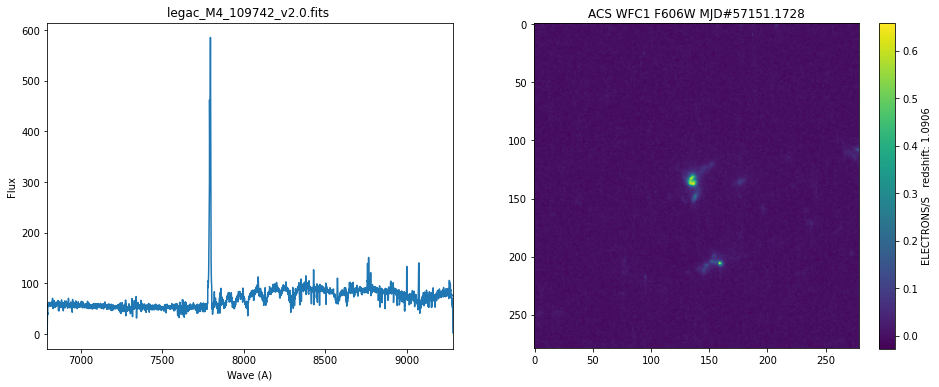

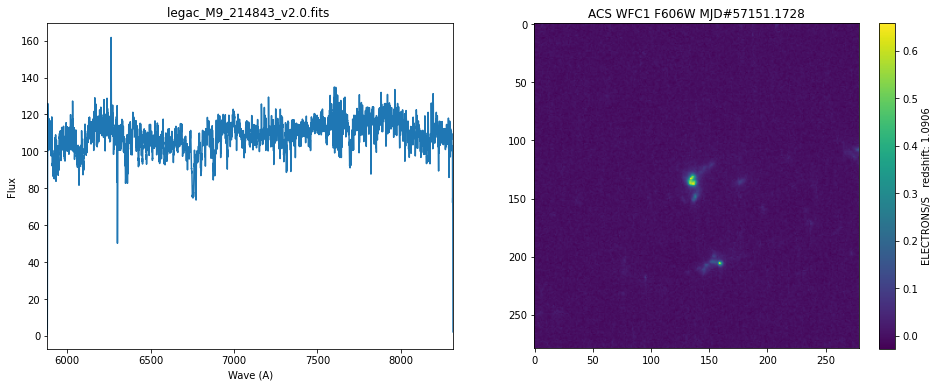

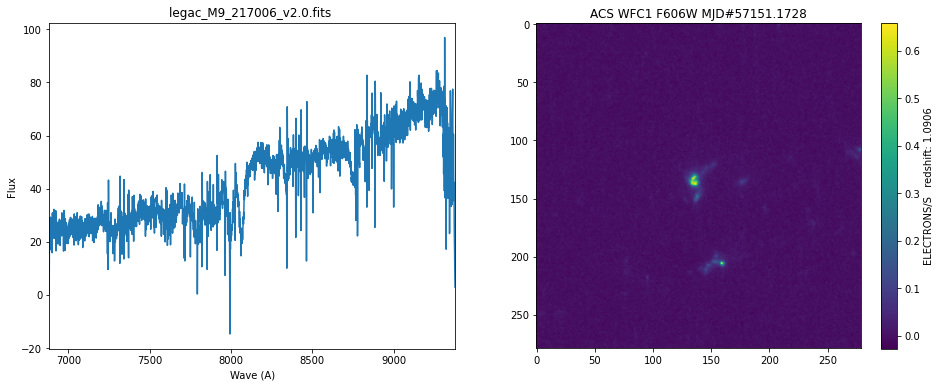

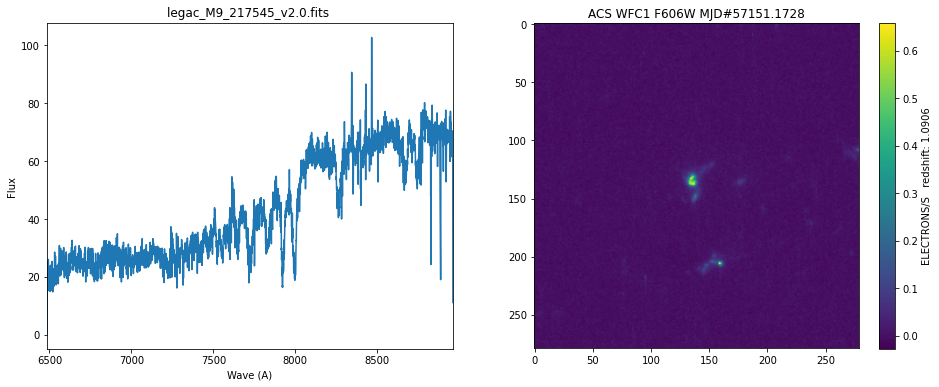

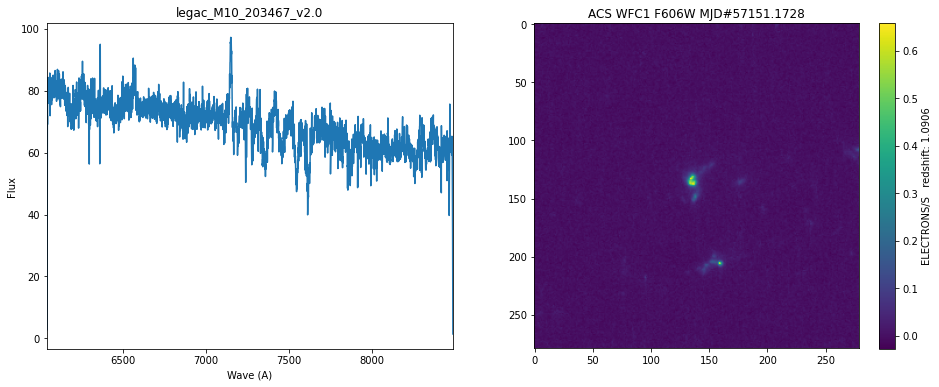

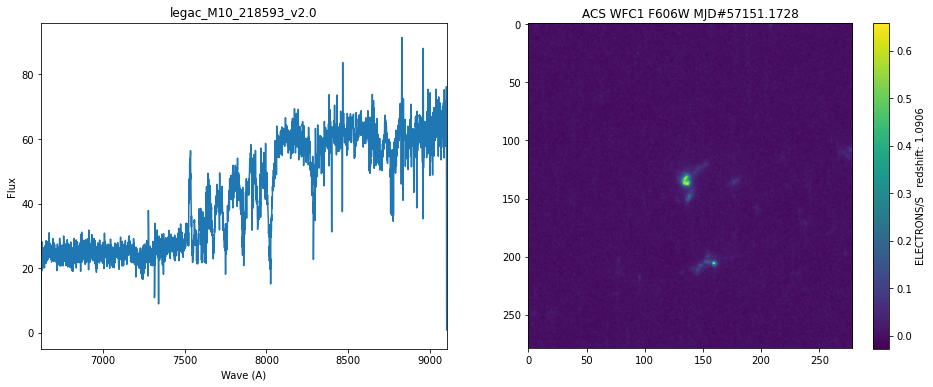

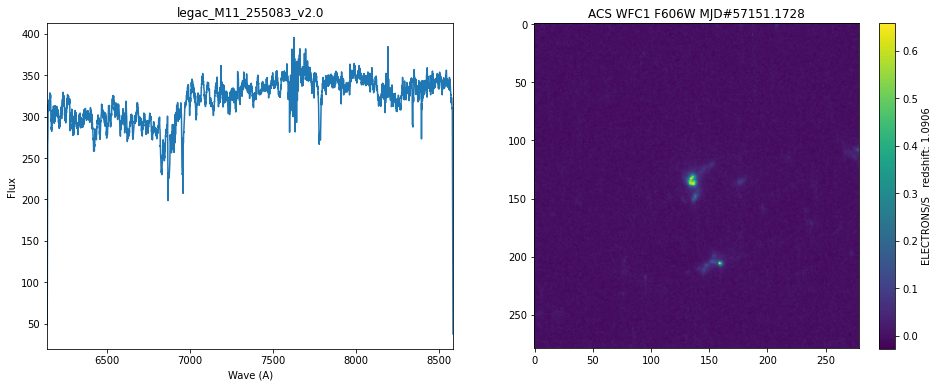

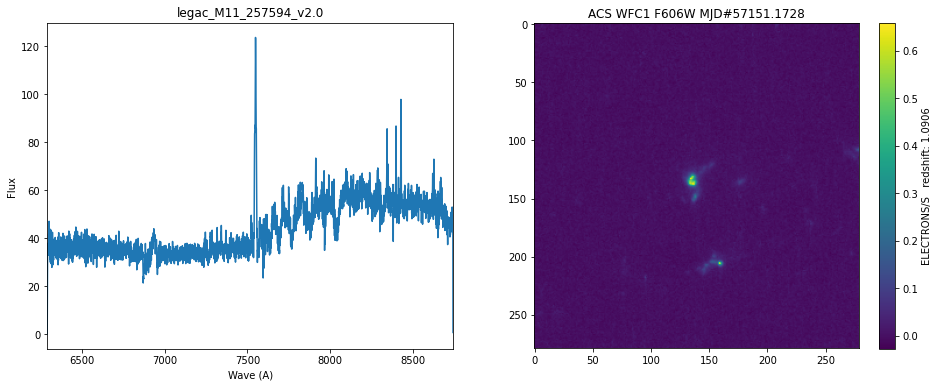

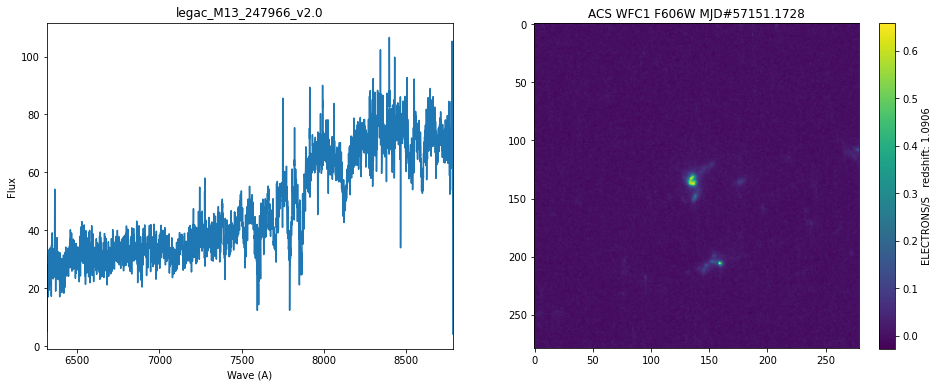

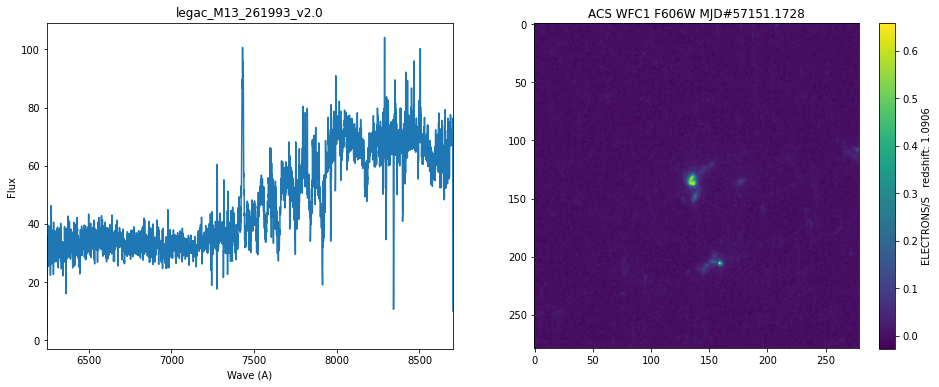

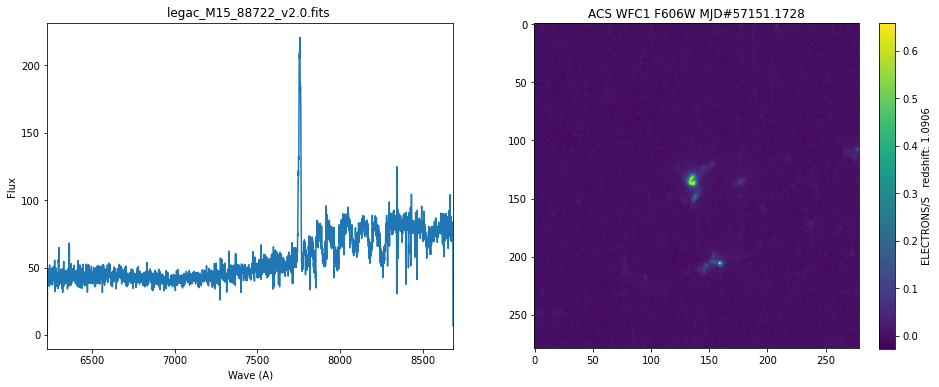

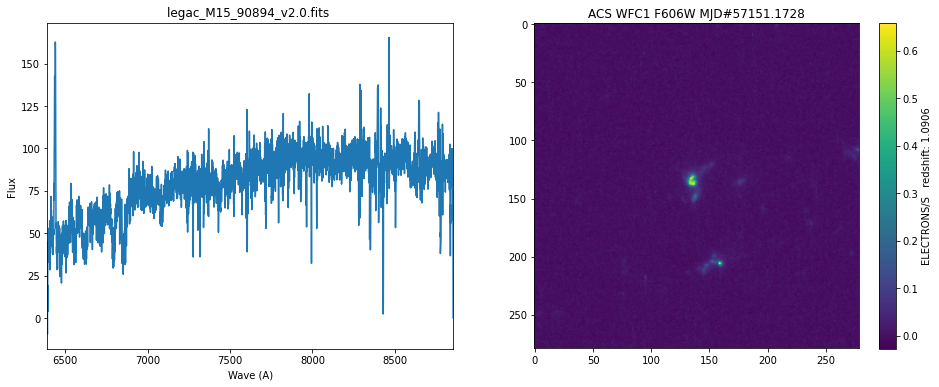

In [68]:
from matplotlib.backends.backend_pdf import PdfPages

#Plot figures

num_of_plots = len(samp_filenames)
plots_per_page = 5
    
    
# if n%5 == 0:
#     num_of_pages = n//5
# else:
#     num_of_pages = n//5 + 1
num_of_pages = int(np.ceil(num_of_plots / float(plots_per_page)))


# pp = PdfPages('multipage_test.pdf')

# try / except : in case there are no images for the fits file ....s etc
# try:  to plot spectra with corresponding img 
# except: pass



# for i in range(num_of_pages): 
    
pp = PdfPages('multipage_test.pdf') 
# ^^ where to create pdf object so it actually creates a new page only after 5 plots are saved? or need to add subplots to fig plots?

for i, file in enumerate(samp_filenames): # wont always work...
    

    obj0 = fits.open('./spectraDR/'+file.strip())
    wave = obj0[1].data['WAVE'][0]
    flux = obj0[1].data['FLUX'][0]

    #Masking to plot only nonzero values of flux (to just look at the interesting parts of the spectra)
    flux_cutoff = np.where(flux != 0)
    flux = flux[flux_cutoff]

    #Plot wave only where flux != 0
    wave = wave[flux_cutoff]



    f, a = plt.subplots(1,2,figsize=(8*2,6))       # to save 5 pair plors on each pg, maybe add more subplots? (5,2)    
    a[0].plot(wave, flux,'-')
    a[0].set_xlabel('Wave (A)')
    a[0].set_ylabel('Flux')
    a[0].set_xlim(wave[0],wave[-1]) # set lims to fit plot to figure 
    spec_name = file.split('.fits')[0]
    a[0].set_title(file.strip('.fits').strip('fits'))


    photname = fits_list[0]['SCI'].header['PHOTMODE']
    units = fits_list[0]['SCI'].header['BUNIT']
    im = a[1].imshow(fits_list[0]['SCI'].data)
    cbar = f.colorbar(im)
    a[1].set_title(photname)
    cbar.set_label(str(units) + '   redshift: '+ str(samp_z[0]))

    
#     if (i+1) % plots_per_page == 0 or (i+1) == num_of_plots:
        
pp.savefig()

    #saves the previous figure to a page here
#         pp.savefig()

    #Close pdf object writing the pdf
#     pp.close()